# Experimentation

## Dataset profiling

In [1]:
%matplotlib inline
import random
import math

import matplotlib.pyplot as plt
import numpy as np

import soli_start
from reviews_soli import ReviewsSolicitation
from data_model import Feature
import uncertainty

file_path = 'datasets/edmunds_reviews.csv'
dataset_profile = soli_start.probe_dataset(file_path)
print(dataset_profile)

Dataset of 5 stars, with 501 products and 53440 reviews
average of feature_rating_count/product = 77.766



Statistics of #reviews/product: min=1, max=1294, average=106.667, std=148.622, median=52.0


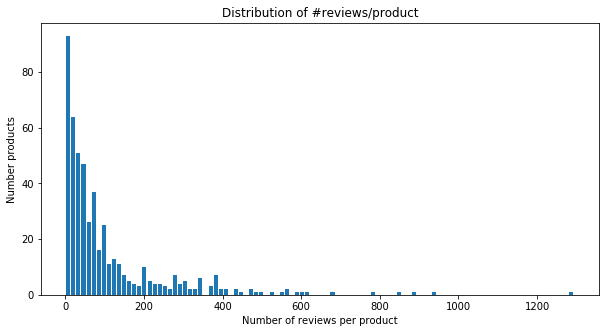

In [2]:
# Distribution of #reviews/product
temp = dataset_profile.per_product_review_counts
print('Statistics of #reviews/product: min={min}, max={max}'
      ', average={average:.3f}, std={std:.3f}, median={median}' \
      .format(min=np.amin(temp), max=np.amax(temp),
              average=np.average(temp), std=np.std(temp), median=np.median(temp)))

fig, ax = plt.subplots(figsize=(10, 5))
_ = ax.hist(dataset_profile.per_product_review_counts, bins=100, rwidth=0.8)
ax.set_xlabel('Number of reviews per product')
ax.set_ylabel('Number products')
ax.set_title('Distribution of #reviews/product')
plt.show()

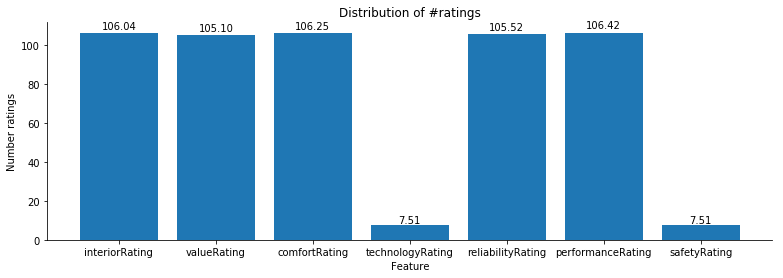

In [3]:
# Distribution of #feature_rating/product
fig, ax = plt.subplots(figsize=(13, 4))
features = list(dataset_profile.feature_to_review_count_average.keys())
num_ratings = list(dataset_profile.feature_to_review_count_average.values())
x_pos = np.arange(len(features))
rects = ax.bar(x_pos, num_ratings)

ax.set_xlabel('Feature')
ax.set_ylabel('Number ratings')
ax.set_title('Distribution of #ratings')
ax.set_xticks(x_pos)
ax.set_xticklabels(features)

for rect, num_rating in zip(rects, num_ratings):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., 1.01*height,
            '{:.2f}'.format(num_rating), ha='center', va='bottom')
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

## Simulation

In [8]:
def plot_pick_answer_methods(pick_answer_to_sim_stats, poll_max=100):
    sim_stats_sample = list(pick_answer_to_sim_stats.values())[0]
    metrics = sim_stats_sample.uncertainty_reports[0].metrics()
    markers = ['o', '^', '>', 's', 'd', '*', 'x', '1', '2', '+']
    
    X = list(sim_stats_sample.polls)[1:poll_max]
    fig, axarr = plt.subplots(len(metrics), 2,
                              figsize=(16, 50), sharex=False, sharey=False,
                              subplot_kw=dict(title='Cost change over polls',
                                              xlabel='Number of polls'))
    for metric_idx, metric in enumerate(metrics):
        for pick_answer_method, sim_stats in pick_answer_to_sim_stats.items():           
            Y = [report.get_metric(metric) for report in sim_stats.uncertainty_reports[1:poll_max]]
            pick_method, answer_method = pick_answer_method
            if answer_method.endswith('_gen'):
                axarr[metric_idx, 0].plot(X, Y, label=pick_method + ' - ' + answer_method)
            else:
                axarr[metric_idx, 1].plot(X, Y, label=pick_method + ' - ' + answer_method)

        for ax in axarr[metric_idx, :]:
            ax.set_ylabel(str(metric))
            ax.legend(loc='upper right')
        
    plt.show()


def plot_no_answer_count(pick_answer_to_sim_stats):
    no_answer_counts = [stat.no_answer_count
                        for stat in pick_answer_to_sim_stats.values()]
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw={'title':'No answer count',
                                                       'xlabel':'#No answer'})
    y_pos = np.arange(len(pick_answer_to_sim_stats))
    rects = ax.barh(y_pos, no_answer_counts, align='center')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels([pick_method + ' - ' + answer_method
                        for pick_method, answer_method
                        in pick_answer_to_sim_stats.keys()])

    for rect, count in zip(rects, no_answer_counts):
        ax.text(rect.get_x() + rect.get_width() + 10,
                rect.get_y() + rect.get_height()/2,
                count, ha='left', va='center')
    plt.show()

-----Duplicated features scenario-----

Experiment with optimization goal: dirichlet_var_sum



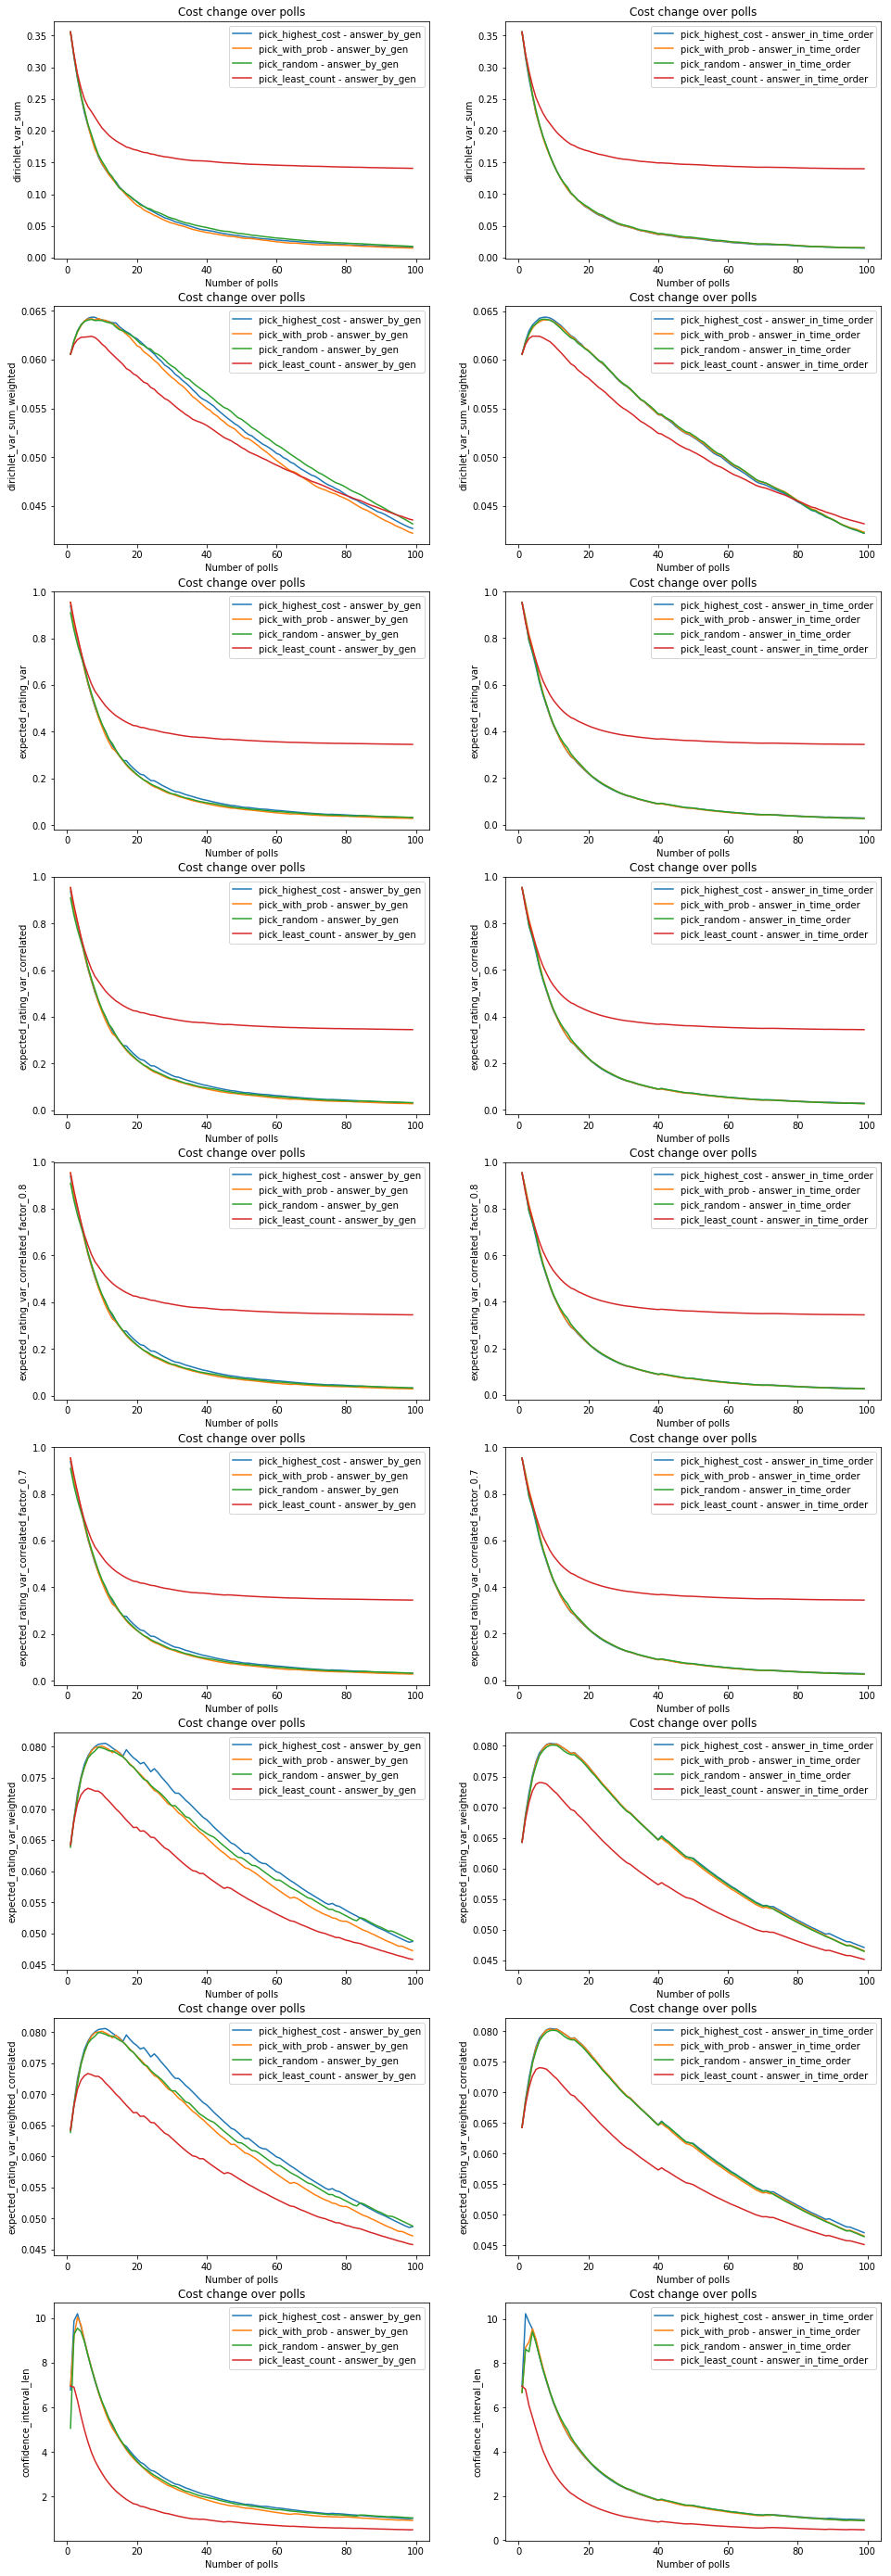

Experiment with optimization goal: dirichlet_var_sum_weighted



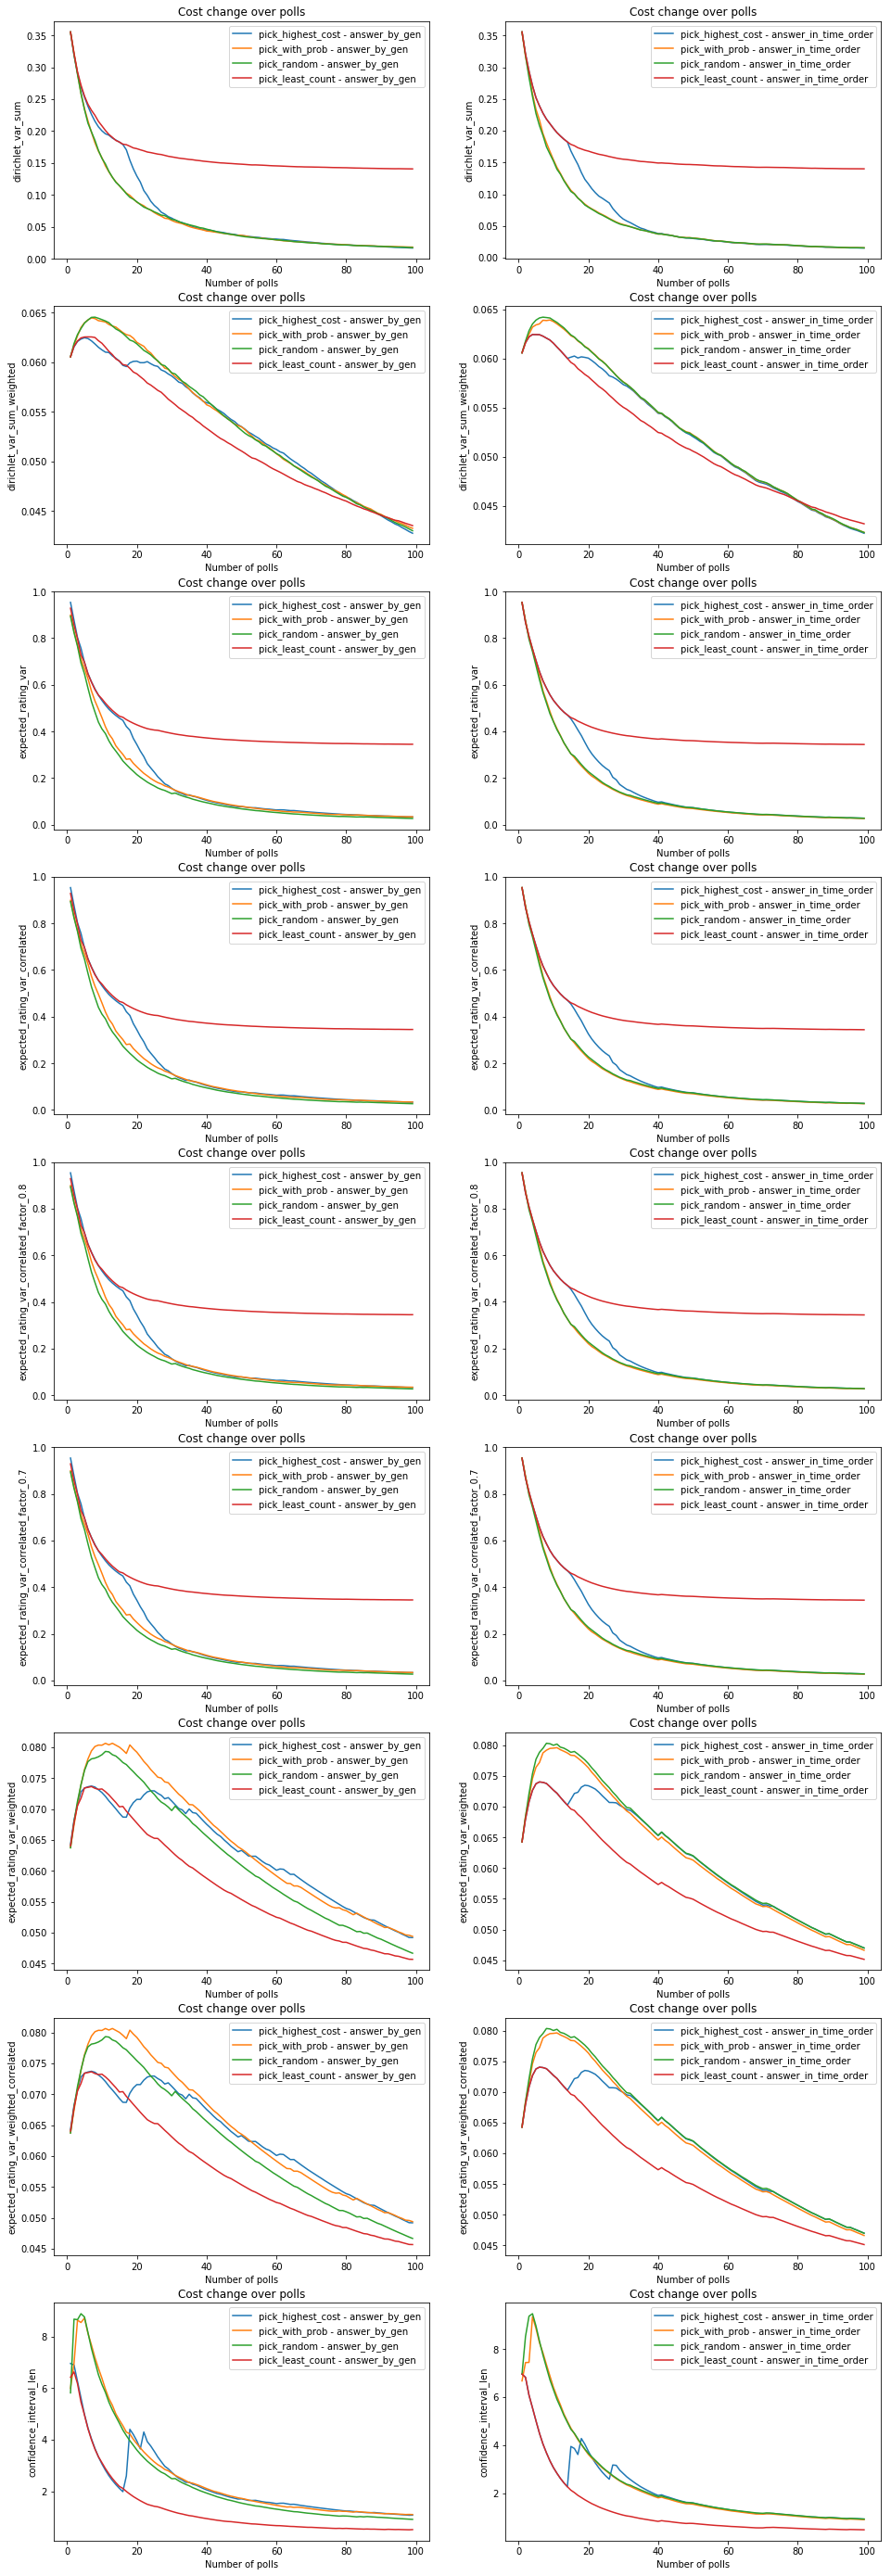

Experiment with optimization goal: expected_rating_var



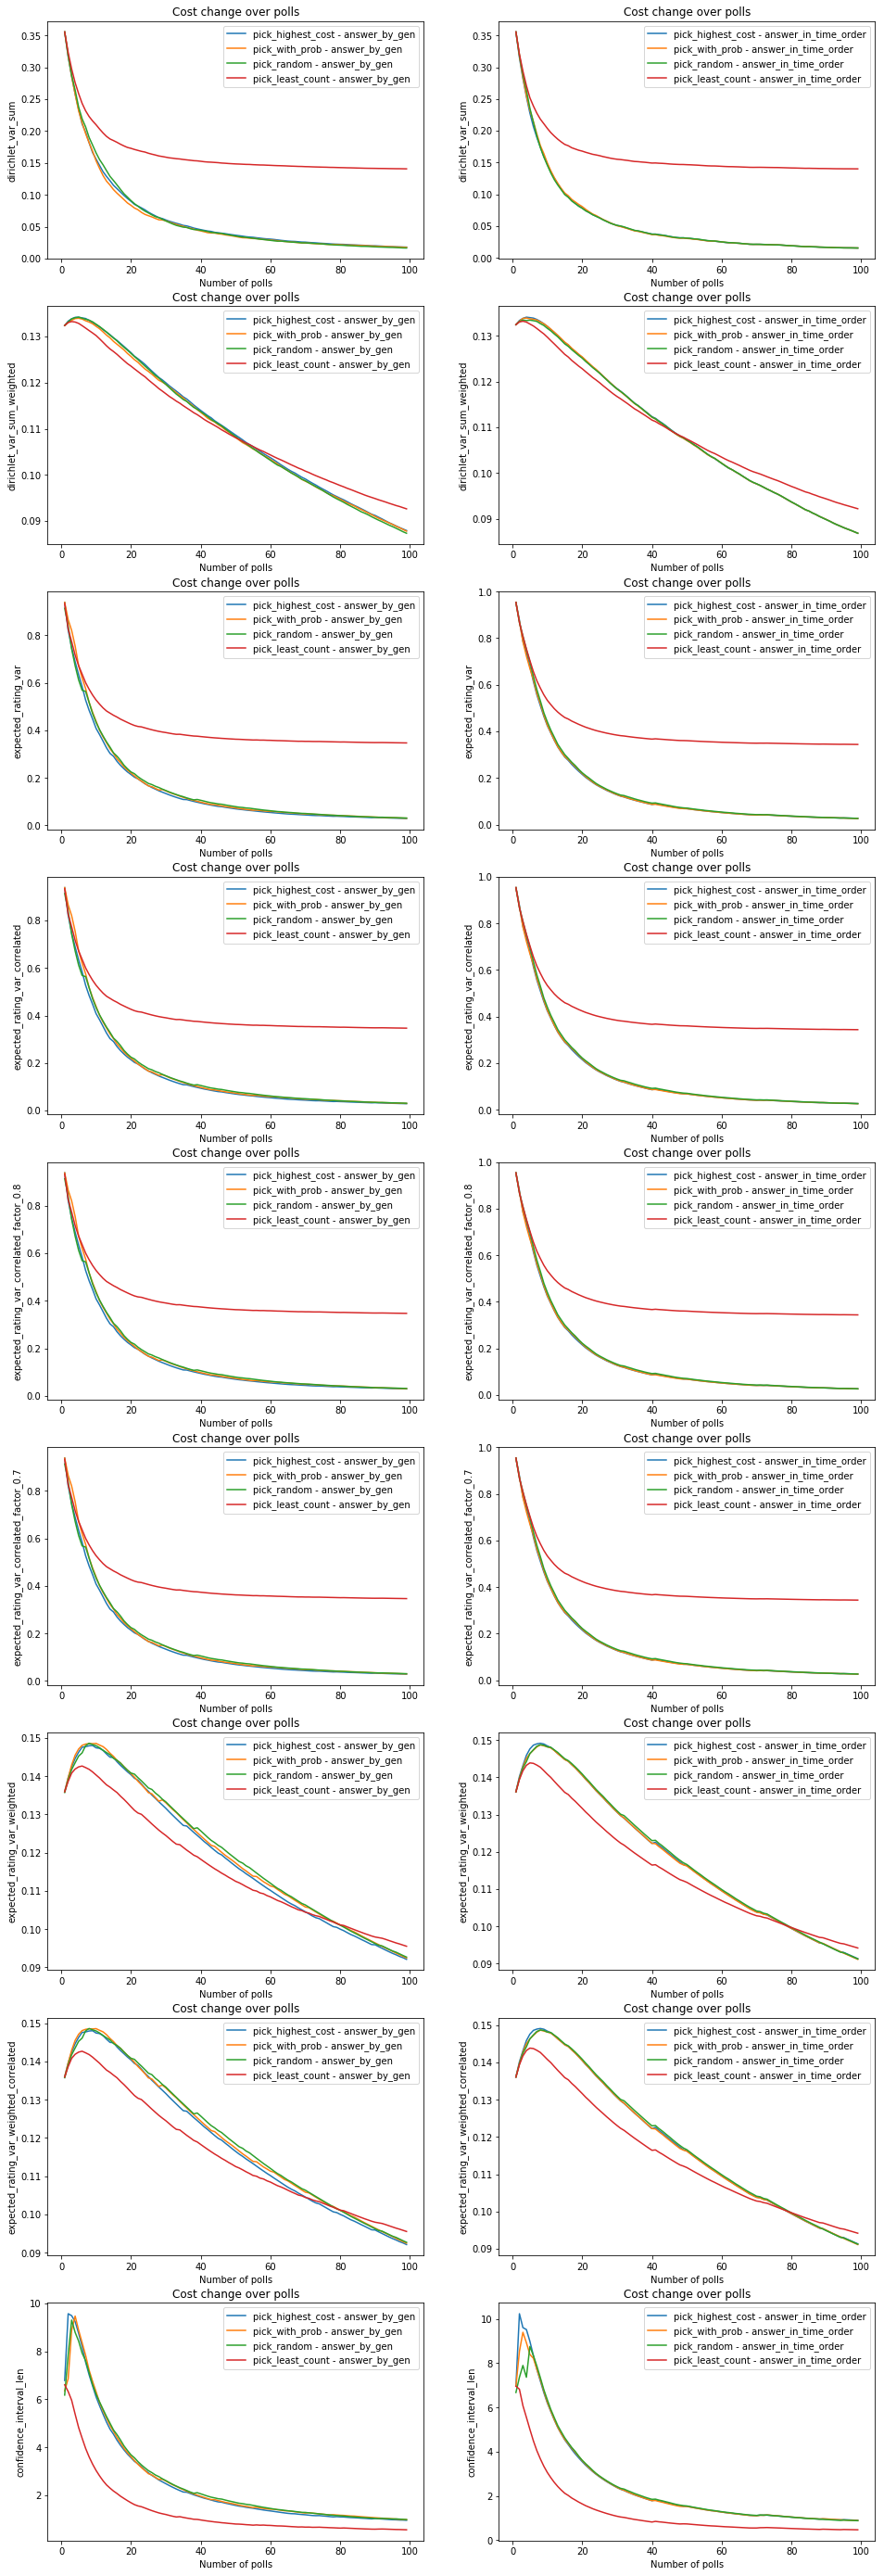

Experiment with optimization goal: expected_rating_var_correlated



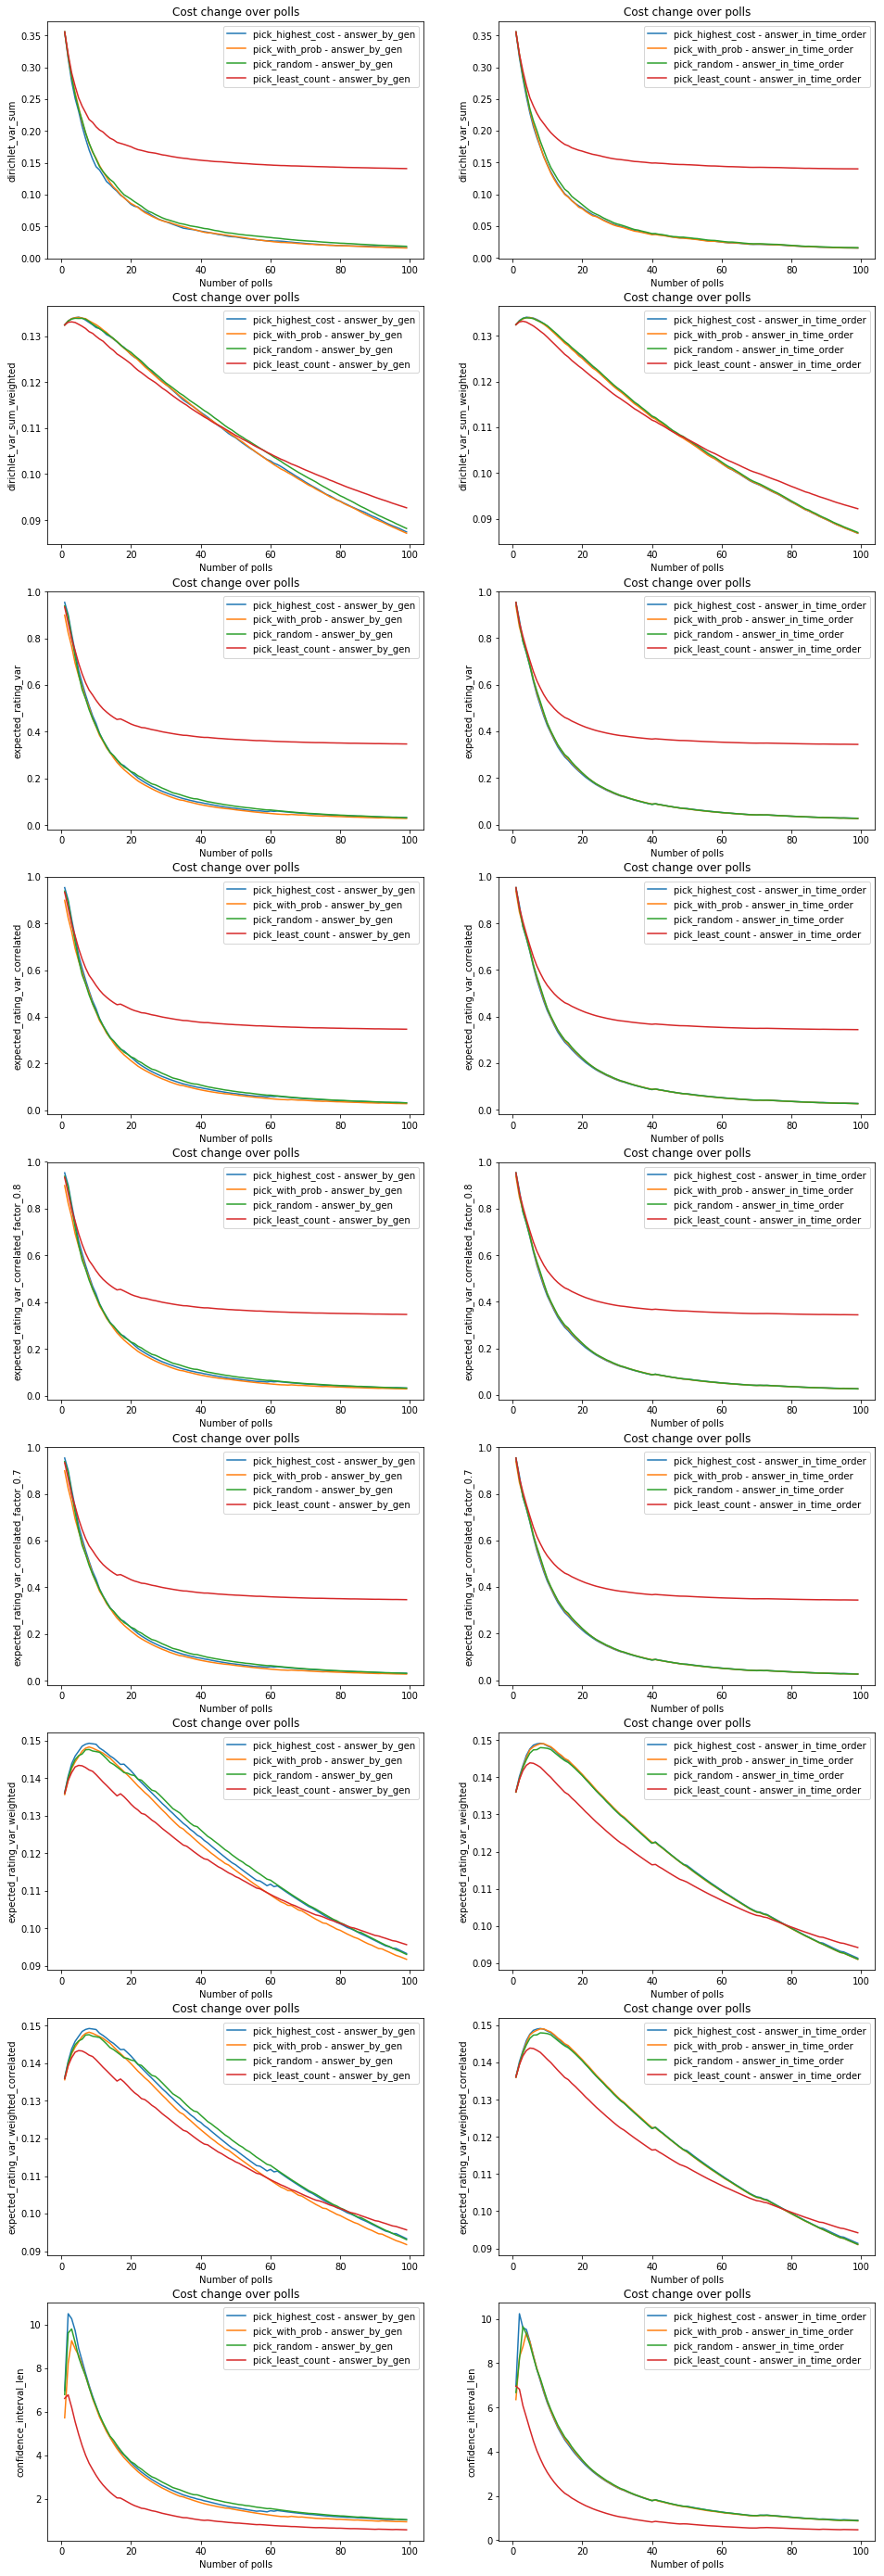

Experiment with optimization goal: expected_rating_var_correlated_factor_0.8



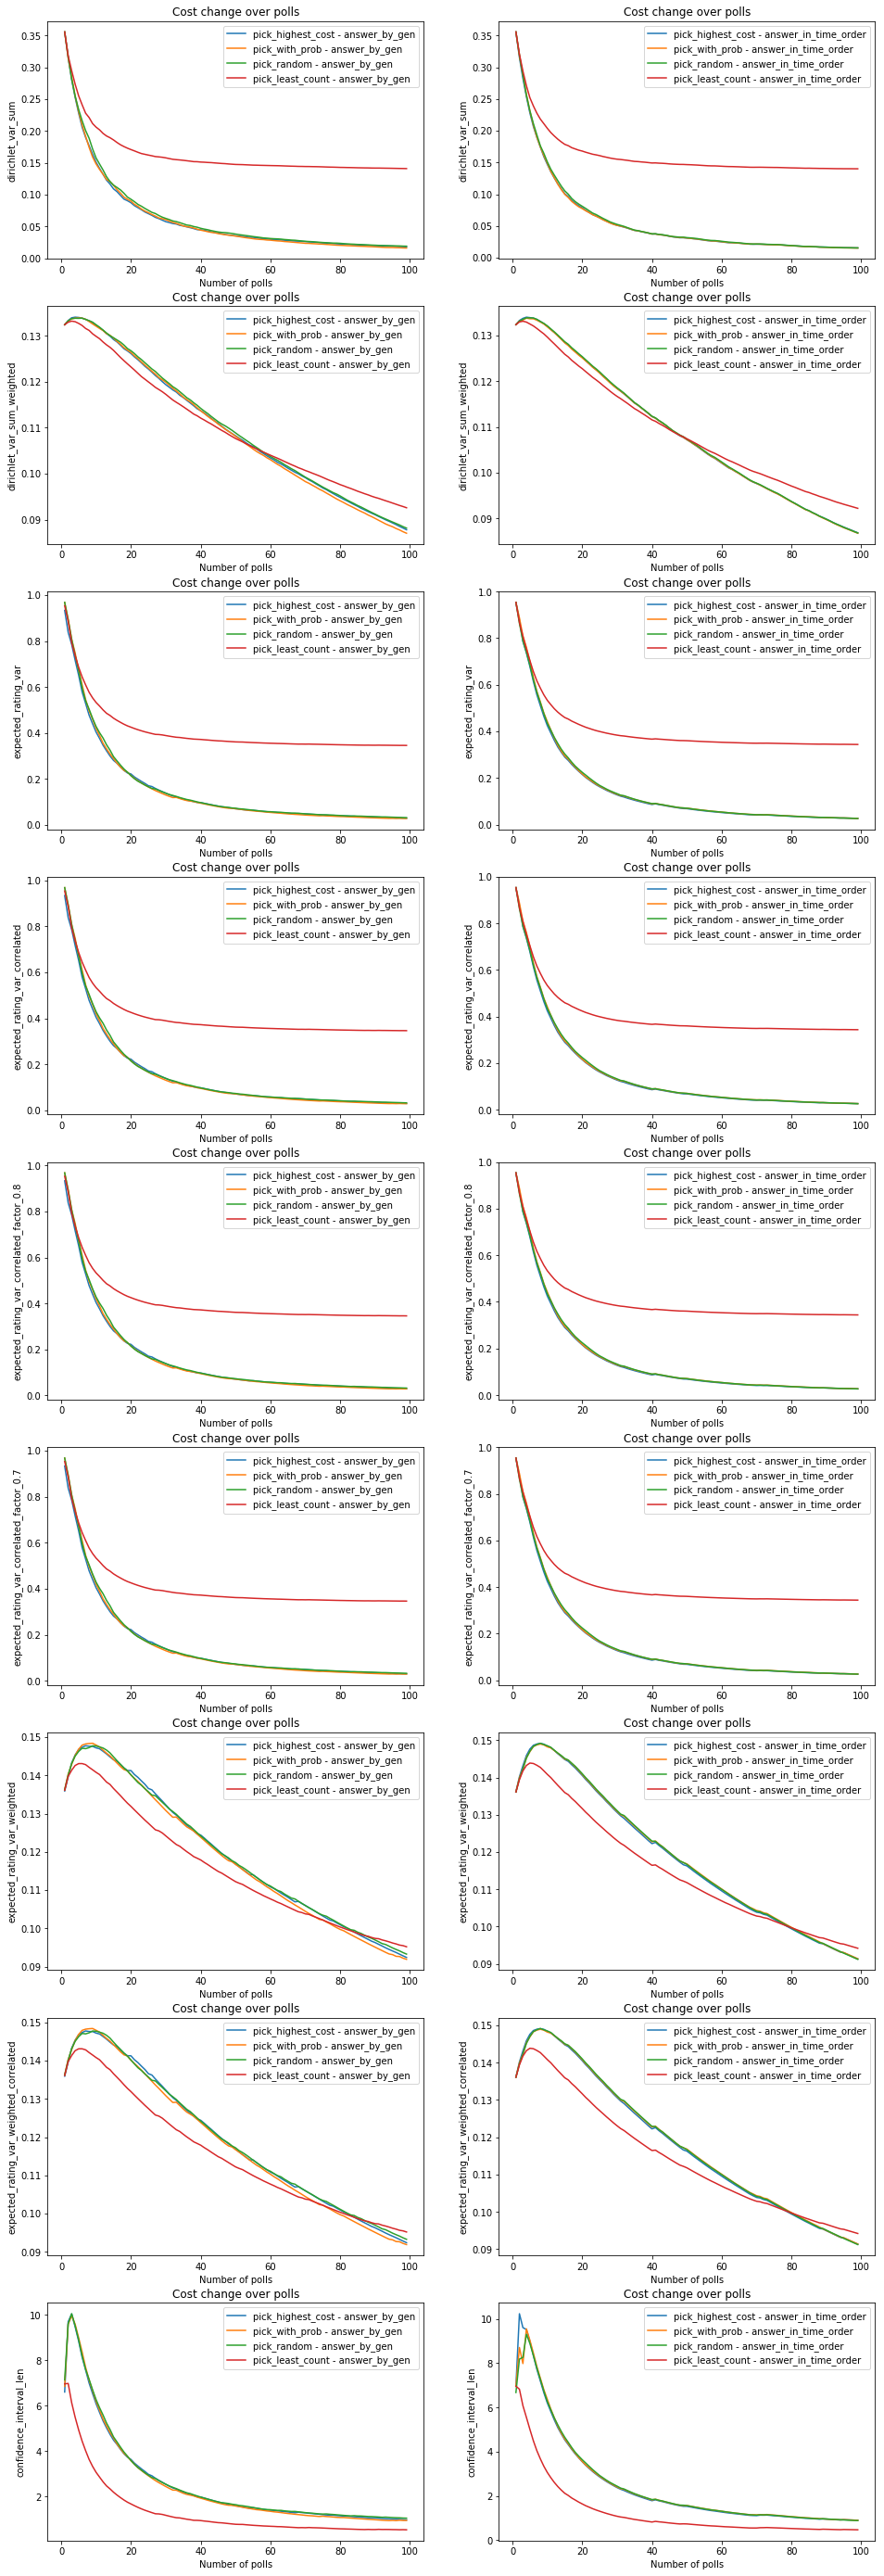

Experiment with optimization goal: expected_rating_var_correlated_factor_0.7



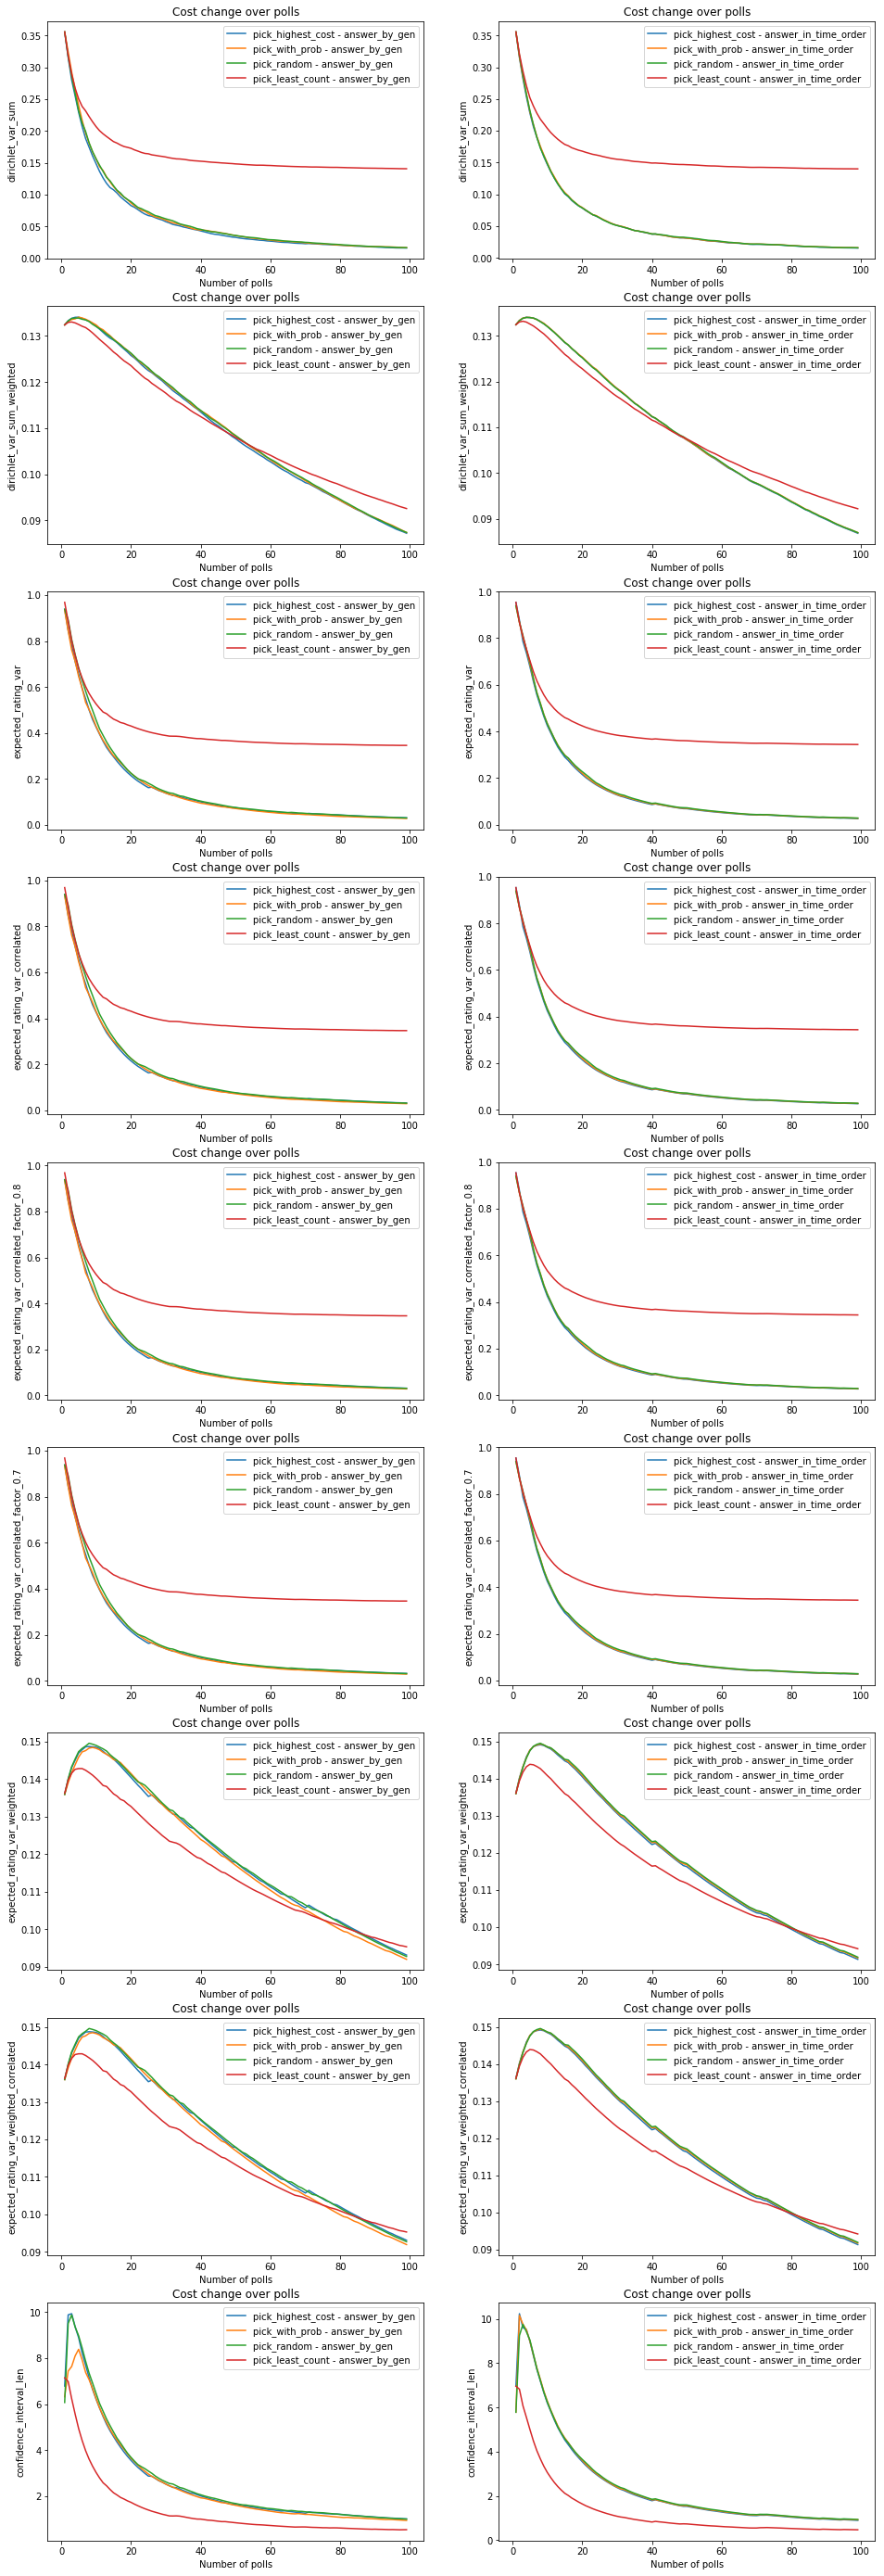

AttributeError: 'UncertaintyMetric' object has no attribute 'cor_norm_factor'

In [9]:
import pickle
import soli_start

sim_result_paths = ['output/result_duplicate.pickle', 'output/result.pickle']
for sim_result_path in sim_result_paths:
    if sim_result_path.rfind('duplicate') >= 0:
        print('-----Duplicated features scenario-----\n')
    with open(sim_result_path, 'rb') as f:
        optim_goal_to_product_result_stats = pickle.load(f)

    for optim_goal, product_to_result_stats in \
            optim_goal_to_product_result_stats.items():    
        print('Experiment with optimization goal: {}\n'.format(str(optim_goal)))
        pick_answer_to_sim_stats_summary = soli_start.summary_sim_stats(product_to_result_stats)
        plot_pick_answer_methods(pick_answer_to_sim_stats_summary,
                                 poll_max=100)